In [1]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
import torch
from transformers import AutoProcessor, CLIPModel


In [6]:
airbnb = pd.read_csv("airbnb-listings.csv", delimiter=";")


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,2,27,66) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [141]:
airbnb.shape

(494954, 89)

In [142]:
pd.set_option('display.max_columns', None)
airbnb.head()

ID                            Listing Url       Scrape ID  \
0   6017649   https://www.airbnb.com/rooms/6017649  20170402075052   
1   9192415   https://www.airbnb.com/rooms/9192415  20170402075052   
2    743788    https://www.airbnb.com/rooms/743788  20170402075052   
3  13153299  https://www.airbnb.com/rooms/13153299  20170402075052   
4    277011    https://www.airbnb.com/rooms/277011  20170402075052   

  Last Scraped                                               Name  \
0   2017-04-02                            Nice room at Vondelpark   
1   2017-04-02                    Cozy apartment center Amsterdam   
2   2017-04-02                  Le Quartier Sonang-Kamar Bidadari   
3   2017-04-02  Trendy and spacious rooftop apt (115m2) in centre   
4   2017-04-02                 nice apartment in centre amsterdam   

                                             Summary  \
0  Nice and clean private bedroom near the city c...   
1  Cozy 2 person apartment in Amsterdam on walkin...   
2  ‘Le Quartier Sonang’ is a peaceful, quiet town...   
3  A beautiful 2 bedroom apt (115 m2) with a an a...   
4                                                NaN   

                                               Space  \
0  I offer a cuzy, private room in a nice apartme...   
1  The appartment has a living room, a kitchen, a...   
2  We opened our doors on the 25th of April 2012 ...   
3  This spacious top floor apartment is completel...   
4  This beautiful apartment has a spacious living...   

                                         Description Experiences Offered  \
0  Nice and clean private bedroom near the city c...                none   
1  Cozy 2 person apartment in Amsterdam on walkin...                none   
2  ‘Le Quartier Sonang’ is a peaceful, quiet town...                none   
3  A beautiful 2 bedroom apt (115 m2) with a an a...                none   
4  This beautiful apartment has a spacious living...                none   

                               Neighborhood Overview Notes  \
0                 Really nice and quiet nighborhood!   NaN   
1  This is an apartment situated at the West side...   NaN   
2                                                NaN   NaN   
3  Seriously one of the best neighbourhoods in to...   NaN   
4                                                NaN   NaN   

                                             Transit  \
0  Directly train connection to Central Station a...   
1  Vondelpark, Museum Square, Leidsplein is on wa...   
2                                                NaN   
3  1 min walk to public transportation which will...   
4                                                NaN   

                                              Access  \
0  Acces to shared use of the bathroom facilities...   
1                                                NaN   
2                                                NaN   
3  If the weather permits, make sure to enjoy the...   
4                                                NaN   

                                         Interaction  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  We are at your disposal and if not around we w...   
4                                                NaN   

                                         House Rules  \
0                                                NaN   
1  -smoking in the house is strictly forbidden, b...   
2  The most important houserule is that you are g...   
3  Feel at home. Please respect the neighbours an...   
4                                                NaN   

                                       Thumbnail Url  \
0  https://a0.muscache.com/im/pictures/74942550/4...   
1  https://a0.muscache.com/im/pictures/eb9e20e1-9...   
2  https://a0.muscache.com/im/pictures/10232036/f...   
3  https://a0.muscache.com/im/pictures/4aad80ac-8...   
4  https://a0.muscache.com/im/pictures/10

Remove columns that are obviously irrelevant or entirely free text (e.g. description, name)

In [143]:
pd.set_option('display.max_columns', None)
relevant_columns = [15,8,22,25,26,27,31,33,38,39,41,44,47,48,49,50,51,52,53,54,55,56,59,60,
                    61,62,63,64,65,66,67,68,69,70,72,75,76,77,78,79,80,81,82,84,86,88]
airbnb2 = airbnb.iloc[:,relevant_columns]
airbnb2.head()

Thumbnail Url Experiences Offered  \
0  https://a0.muscache.com/im/pictures/74942550/4...                none   
1  https://a0.muscache.com/im/pictures/eb9e20e1-9...                none   
2  https://a0.muscache.com/im/pictures/10232036/f...                none   
3  https://a0.muscache.com/im/pictures/4aad80ac-8...                none   
4  https://a0.muscache.com/im/pictures/10553335/6...                none   

   Host Since  Host Response Time  Host Response Rate Host Acceptance Rate  \
0  2011-09-22                 NaN                 NaN                  NaN   
1  2015-10-31  within a few hours               100.0                  NaN   
2  2012-10-17        within a day               100.0                  NaN   
3  2014-07-04  within a few hours               100.0                  NaN   
4  2011-11-27      within an hour               100.0                  NaN   

   Host Listings Count                                 Host Verifications  \
0                  1.0                       email,phone,facebook,reviews   
1                  1.0            email,phone,reviews,jumio,government_id   
2                  3.0                                email,phone,reviews   
3                  1.0  email,phone,reviews,jumio,offline_government_i...   
4                  1.0            email,phone,facebook,reviews,work_email   

        City          State     Market      Country    Property Type  \
0  Amsterdam  Noord-Holland  Amsterdam  Netherlands        Apartment   
1  Amsterdam  Noord-Holland  Amsterdam  Netherlands        Apartment   
2  Amsterdam  North Holland  Amsterdam  Netherlands  Bed & Breakfast   
3  Amsterdam  Noord-Holland  Amsterdam  Netherlands        Apartment   
4  Amsterdam  North Holland  Amsterdam  Netherlands        Apartment   

         Room Type  Accommodates  Bathrooms  Bedrooms  Beds  Bed Type  \
0     Private room           1.0        1.0       1.0   1.0  Real Bed   
1  Entire home/apt           2.0        1.0       1.0   1.0  Real Bed   
2     Private room           2.0        1.0       1.0   1.0  Real Bed   
3  Entire home/apt           4.0        1.0       2.0   3.0  Real Bed   
4  Entire home/apt           2.0        1.0       1.0   1.0  Real Bed   

                                           Amenities  Square Feet  Price  \
0  Internet,Wireless Internet,Kitchen,Heating,Was...          NaN   50.0   
1  TV,Cable TV,Internet,Wireless Internet,Kitchen...          NaN   95.0   
2  TV,Internet,Wireless Internet,Breakfast,Heatin...        323.0  160.0   
3  TV,Cable TV,Internet,Wireless Internet,Kitchen...          NaN  175.0   
4  Wireless Internet,Kitchen,Hot tub,Buzzer/wirel...          NaN  100.0   

   Security Deposit  Cleaning Fee  Guests Included  Extra People  \
0               NaN           NaN              1.0           0.0   
1               NaN          15.0              2.0          40.0   
2               NaN           NaN              1.0           0.0   
3             250.0          50.0              2.0          40.0   
4               NaN           NaN              2.0          15.0   

   Minimum Nights  Maximum Nights Calendar Updated Has Availability  \
0             1.0          1125.0    22 months ago              NaN   
1             2.0             7.0     2 months ago              NaN   
2             2.0            14.0            today              NaN   
3            12.0            21.0      5 weeks ago              NaN   
4             4.0           760.0     2 months ago              NaN   

   Availability 30  Availability 60  Availability 90  Availability 365  \
0              0.0              0.0              0.0               0.0   
1              0.0              0.0              0.0               0.0   
2              3.0              4.0             13.0             178.0   
3              1.0              1.0              1.0             148.0   
4              0.0              0.0              0.0               0.0   

   Number of Reviews  Review Scores Rati

In [144]:
airbnb2.describe()

Host Response Rate  Host Listings Count   Accommodates      Bathrooms  \
count       379884.000000        494449.000000  494891.000000  493428.000000   
mean            93.376549             9.549721       3.311584       1.249632   
std             17.592441            57.199523       2.094052       0.607029   
min              0.000000             0.000000       1.000000       0.000000   
25%             98.000000             1.000000       2.000000       1.000000   
50%            100.000000             1.000000       2.000000       1.000000   
75%            100.000000             3.000000       4.000000       1.000000   
max            100.000000          1114.000000      21.000000      10.000000   

            Bedrooms           Beds    Square Feet          Price  \
count  494328.000000  494037.000000   12209.000000  486996.000000   
mean        1.378322       1.934525     575.544762     138.072703   
std         0.942508       1.488128    1825.903405     149.670499   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000      55.000000   
50%         1.000000       1.000000     377.000000      90.000000   
75%         2.000000       2.000000     800.000000     150.000000   
max        96.000000      19.000000  129167.000000     999.000000   

       Security Deposit   Cleaning Fee  Guests Included   Extra People  \
count     204012.000000  315715.000000    494952.000000  494917.000000   
mean         274.126703      62.267906         1.550235      12.028728   
std          171.605763      75.746943         1.224923      31.189786   
min            0.000000       0.000000         0.000000       0.000000   
25%          150.000000      20.000000         1.000000       0.000000   
50%          200.000000      40.000000         1.000000       0.000000   
75%          350.000000      75.000000         2.000000      15.000000   
max          999.000000     999.000000        20.000000     999.000000   

       Minimum Nights  Maximum Nights  Availability 30  Availability 60  \
count   494952.000000    4.949520e+05    494952.000000    494952.000000   
mean         3.470415    2.123406e+05         9.961726        22.997256   
std         89.396359    2.024385e+07        10.981093        22.351102   
min          1.000000    1.000000e+00         0.000000         0.000000   
25%          1.000000    3.200000e+01         0.000000         0.000000   
50%          2.000000    1.125000e+03         5.000000        17.000000   
75%          3.000000    1.125000e+03        19.000000        44.000000   
max      60000.000000    2.147484e+09        30.000000        60.000000   

       Availability 90  Availability 365  Number of Reviews  \
count    494952.000000     494952.000000      494952.000000   
mean         37.878594        166.092332          16.740850   
std          33.856420        140.510625          32.336701   
min           0.000000          0.000000           0.000000   
25%           0.000000         14.000000           1.000000   
50%          33.000000        148.000000           4.000000   
75%          71.000000        313.000000          18.000000   
max          90.000000        365.000000         735.000000   

       Review Scores Rating  Review Scores Accuracy  \
count         367134.000000           366237.000000   
mean              92.913988                9.527773   
std                8.543725                0.852536   
min               20.000000                2.000000   
25%               90.000000                9.000000   
50%               95.000000               10.000000   
75%              100.000000               10.000000   
max              100.000000               10.000000   

       Review Scores Cleanliness  Review Scores Checkin  \
count              366479.000000          365918.000000   
mean                    9.328483               9.692770   
std                     1.035356               0.727947   
min                  

In [11]:
pd.set_option('display.max_rows', None)
airbnb2.dtypes

Thumbnail Url                   object
Experiences Offered             object
Host Since                      object
Host Response Time              object
Host Response Rate             float64
Host Acceptance Rate            object
Host Listings Count            float64
Host Verifications              object
City                            object
State                           object
Market                          object
Country                         object
Property Type                   object
Room Type                       object
Accommodates                   float64
Bathrooms                      float64
Bedrooms                       float64
Beds                           float64
Bed Type                        object
Amenities                       object
Square Feet                    float64
Price                          float64
Security Deposit               float64
Cleaning Fee                   float64
Guests Included                float64
Extra People             

Check for missing values

In [145]:
pd.set_option('display.max_rows', None)
airbnb2.isnull().sum()

Thumbnail Url                   94834
Experiences Offered                 0
Host Since                        505
Host Response Time             115069
Host Response Rate             115070
Host Acceptance Rate           452696
Host Listings Count               505
Host Verifications                336
City                              454
State                           49794
Market                           5655
Country                             3
Property Type                      11
Room Type                           1
Accommodates                       63
Bathrooms                        1526
Bedrooms                          626
Beds                              917
Bed Type                            1
Amenities                        4488
Square Feet                    482745
Price                            7958
Security Deposit               290942
Cleaning Fee                   179239
Guests Included                     2
Extra People                       37
Minimum Nigh

Remove rows without Price or Thumbnail Url

In [146]:
drop_columns = ["Thumbnail Url", "Price"]
airbnb3 = airbnb2.dropna(subset=drop_columns)
len(airbnb3)

394894

In [147]:
airbnb3.isnull().sum()

Thumbnail Url                       0
Experiences Offered                 0
Host Since                        395
Host Response Time              87489
Host Response Rate              87490
Host Acceptance Rate           359081
Host Listings Count               394
Host Verifications                266
City                              379
State                           38520
Market                           4652
Country                             2
Property Type                       9
Room Type                           0
Accommodates                        1
Bathrooms                        1106
Bedrooms                          476
Beds                              728
Bed Type                            0
Amenities                        3319
Square Feet                    386250
Price                               0
Security Deposit               233694
Cleaning Fee                   144870
Guests Included                     1
Extra People                       14
Minimum Nigh

Drop additional columns due to missing values or redundant information

In [148]:
airbnb4 = airbnb3.drop(columns = ["Host Acceptance Rate", "Square Feet", "Security Deposit", "Has Availability", "License", "State", "City"])
airbnb5 = airbnb4.dropna()
airbnb5 = airbnb5.reset_index(drop=True)
airbnb5.head()

Thumbnail Url Experiences Offered  \
0  https://a0.muscache.com/im/pictures/eb9e20e1-9...                none   
1  https://a0.muscache.com/im/pictures/4aad80ac-8...                none   
2  https://a0.muscache.com/im/pictures/440cb88b-6...                none   
3  https://a0.muscache.com/im/pictures/633ddf5e-a...                none   
4  https://a0.muscache.com/im/pictures/3553991/bb...                none   

   Host Since  Host Response Time  Host Response Rate  Host Listings Count  \
0  2015-10-31  within a few hours               100.0                  1.0   
1  2014-07-04  within a few hours               100.0                  1.0   
2  2014-04-24      within an hour               100.0                  0.0   
3  2014-06-27      within an hour               100.0                  1.0   
4  2011-04-14      within an hour               100.0                  3.0   

                                  Host Verifications     Market      Country  \
0            email,phone,reviews,jumio,government_id  Amsterdam  Netherlands   
1  email,phone,reviews,jumio,offline_government_i...  Amsterdam  Netherlands   
2                                email,phone,reviews  Amsterdam  Netherlands   
3                          email,phone,reviews,jumio  Amsterdam  Netherlands   
4                                email,phone,reviews  Amsterdam  Netherlands   

  Property Type        Room Type  Accommodates  Bathrooms  Bedrooms  Beds  \
0     Apartment  Entire home/apt           2.0        1.0       1.0   1.0   
1     Apartment  Entire home/apt           4.0        1.0       2.0   3.0   
2     Apartment  Entire home/apt           2.0        1.0       1.0   1.0   
3     Apartment  Entire home/apt           2.0        1.0       1.0   1.0   
4     Apartment  Entire home/apt           2.0        1.0       1.0   1.0   

   Bed Type                                          Amenities  Price  \
0  Real Bed  TV,Cable TV,Internet,Wireless Internet,Kitchen...   95.0   
1  Real Bed  TV,Cable TV,Internet,Wireless Internet,Kitchen...  175.0   
2  Real Bed  TV,Internet,Wireless Internet,Kitchen,Heating,...  115.0   
3  Real Bed  TV,Cable TV,Internet,Wireless Internet,Kitchen...   99.0   
4  Real Bed  TV,Cable TV,Internet,Wireless Internet,Kitchen...   90.0   

   Cleaning Fee  Guests Included  Extra People  Minimum Nights  \
0          15.0              2.0          40.0             2.0   
1          50.0              2.0          40.0            12.0   
2          35.0              1.0           0.0             3.0   
3          35.0              2.0          15.0             2.0   
4          40.0              1.0           0.0             2.0   

   Maximum Nights Calendar Updated  Availability 30  Availability 60  \
0             7.0     2 months ago              0.0              0.0   
1            21.0      5 weeks ago              1.0              1.0   
2            14.0            today              0.0              0.0   
3          1125.0            today              0.0              0.0   
4            60.0            today              0.0              0.0   

   Availability 90  Availability 365  Number of Reviews  Review Scores Rating  \
0              0.0               0.0               16.0                  99.0   
1              1.0             148.0                1.0                 100.0   
2              0.0              22.0                1.0                 100.0   
3              7.0               7.0               18.0                  93.0   
4              0.0              16.0              212.0                  98.0   

   Review Scores Accuracy  Review Scores Cleanliness  Review Scores Checkin  \
0                    10.0                       10.0                   10.0   
1                    10.0                       10.0                   10.0   
2                    10.0                       10.0                   10.0   
3                    10.0                       10.0                   10.0   
4                 

In [149]:
len(airbnb5)

176359

In [150]:
airbnb5.columns

Index(['Thumbnail Url', 'Experiences Offered', 'Host Since',
       'Host Response Time', 'Host Response Rate', 'Host Listings Count',
       'Host Verifications', 'Market', 'Country', 'Property Type', 'Room Type',
       'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type',
       'Amenities', 'Price', 'Cleaning Fee', 'Guests Included', 'Extra People',
       'Minimum Nights', 'Maximum Nights', 'Calendar Updated',
       'Availability 30', 'Availability 60', 'Availability 90',
       'Availability 365', 'Number of Reviews', 'Review Scores Rating',
       'Review Scores Accuracy', 'Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores Location', 'Review Scores Value', 'Cancellation Policy',
       'Reviews per Month', 'Features'],
      dtype='object')

Check number of unique values for object attributes

In [151]:
for i in range(len(airbnb5.columns)):
    if airbnb5.dtypes[i] == "object":
        print(airbnb5.columns[i])
        print(len(airbnb5[airbnb5.columns[i]].unique()))

Thumbnail Url
176329
Experiences Offered
5
Host Since
2994
Host Response Time
4
Host Verifications
654
Market
106
Country
19
Property Type
37
Room Type
3
Bed Type
5
Amenities
149941
Calendar Updated
50
Cancellation Policy
11
Features
134


Extract years from "Host Since" and create indicator variables for each year

In [152]:
date_series = pd.to_datetime(airbnb5["Host Since"])
unique_years = date_series.dt.year.unique()
df_host_since = pd.get_dummies(date_series.dt.year, prefix="Host Since")
df_host_since.head()


Host Since_2008  Host Since_2009  Host Since_2010  Host Since_2011  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                1   

   Host Since_2012  Host Since_2013  Host Since_2014  Host Since_2015  \
0                0                0                0                1   
1                0                0                1                0   
2                0                0                1                0   
3                0                0                1                0   
4                0                0                0                0   

   Host Since_2016  Host Since_2017  
0                0                0  
1                0                0  
2                0                0  
3                0                0  
4                0                0

In [153]:
df_host_since.shape

(176359, 10)

Bin "Calendar Updated" in to four more general categories and replace old values

In [154]:
airbnb5["Calendar Updated"].unique()

array(['2 months ago', '5 weeks ago', 'today', '3 days ago',
       '3 weeks ago', 'a week ago', 'yesterday', '2 days ago',
       '5 months ago', '6 months ago', '1 week ago', '4 days ago',
       '6 weeks ago', '2 weeks ago', '5 days ago', '7 weeks ago',
       '4 weeks ago', '6 days ago', '4 months ago', '3 months ago',
       '12 months ago', '7 months ago', '8 months ago', '9 months ago',
       '15 months ago', '11 months ago', '18 months ago', '14 months ago',
       '17 months ago', '10 months ago', 'never', '16 months ago',
       '13 months ago', '23 months ago', '27 months ago', '21 months ago',
       '22 months ago', '19 months ago', '20 months ago', '25 months ago',
       '24 months ago', '36 months ago', '31 months ago', '39 months ago',
       '29 months ago', '30 months ago', '37 months ago', '28 months ago',
       '32 months ago', '40 months ago'], dtype=object)

In [155]:
list_splitted = [s.lower().split() for s in airbnb5["Calendar Updated"]]
temp_list = []
for listing in list_splitted:
    if ("today" in listing) or ("yesterday" in listing) or ("days" in listing) or ("week" in listing):
        temp_list.append("one week or less")
    elif "weeks" in listing and int(listing[0]) < 5:
        temp_list.append("between one week and one month")
    elif "weeks" in listing or ("months" in listing and int(list[0]) < 13):
        temp_list.append("between one month and one year")
    else:
        temp_list.append("more than a year or never")
calendar_updated_new = pd.Series(temp_list, name = "Calendar Updated New")
calendar_copy = airbnb5["Calendar Updated"].copy()
test = pd.DataFrame({'New': calendar_updated_new, 'Old': calendar_copy})
test.head(10)

New           Old
0  between one month and one year  2 months ago
1  between one month and one year   5 weeks ago
2                one week or less         today
3                one week or less         today
4                one week or less         today
5                one week or less    3 days ago
6                one week or less         today
7  between one week and one month   3 weeks ago
8  between one month and one year  2 months ago
9                one week or less    a week ago

In [156]:
airbnb5["Calendar Updated"] = calendar_updated_new
airbnb5["Calendar Updated"].head()

0    between one month and one year
1    between one month and one year
2                  one week or less
3                  one week or less
4                  one week or less
Name: Calendar Updated, dtype: object

Create Indicator variables from string attributes with categories seperated by commas

In [465]:
def check_for_value(value, series):
    temp_list = []
    for listing in series:
        if value in listing:
            temp_list.append(1.)
        else:
            temp_list.append(0.)
    temp_series = pd.Series(temp_list, name=value)
    return temp_series

def indicator_variables_from_string(series):
    list_splitted = [s.lower().split(",") for s in series]
    categories = {value for listing in list_splitted for value in listing}
    df = pd.DataFrame()

    for category in categories:
        df = pd.concat([df, check_for_value(category, list_splitted)], axis=1)
    return df

In [466]:
df_amenities = indicator_variables_from_string(airbnb5["Amenities"])
df_amenities.head()

tv  doorman  roll-in shower with shower bench or chair  step-free access  \
0  1.0      0.0                                        0.0               0.0   
1  1.0      0.0                                        0.0               0.0   
2  1.0      0.0                                        0.0               0.0   
3  1.0      0.0                                        0.0               0.0   
4  1.0      0.0                                        0.0               0.0   

   gym  translation missing: en.hosting_amenity_50  ethernet connection  \
0  0.0                                         1.0                  0.0   
1  0.0                                         0.0                  0.0   
2  0.0                                         1.0                  0.0   
3  0.0                                         0.0                  0.0   
4  0.0                                         0.0                  0.0   

   breakfast  wide clearance to bed  wide doorway  wide hallway clearance  \
0        0.0                    0.0           0.0                     0.0   
1        1.0                    0.0           0.0                     0.0   
2        0.0                    0.0           0.0                     0.0   
3        0.0                    0.0           0.0                     0.0   
4        0.0                    0.0           0.0                     0.0   

   smoking allowed  crib  essentials  wheelchair accessible  washer / dryer  \
0              0.0   0.0         1.0                    0.0             0.0   
1              0.0   0.0         1.0                    0.0             0.0   
2              0.0   0.0         1.0                    0.0             0.0   
3              0.0   0.0         1.0                    0.0             0.0   
4              0.0   0.0         1.0                    0.0             0.0   

   private living room  buzzer/wireless intercom  shampoo  hot water  bathtub  \
0                  0.0                       1.0      1.0        0.0      0.0   
1                  0.0                       1.0      1.0        0.0      0.0   
2                  0.0                       0.0      1.0        0.0      0.0   
3                  0.0                       0.0      1.0        0.0      0.0   
4                  0.0                       1.0      1.0        0.0      0.0   

   smartlock  heating  room-darkening shades  changing table  microwave  \
0        0.0      1.0                    0.0             0.0        0.0   
1        0.0      1.0                    0.0             0.0        0.0   
2        0.0      1.0                    0.0             0.0        0.0   
3        0.0      1.0                    0.0             0.0        0.0   
4        0.0      1.0                    0.0             0.0        0.0   

   self check-in  doorman entry  bbq grill  free parking on premises  \
0            0.0            0.0        0.0                       0.0   
1            0.0            0.0        0.0                       0.0   
2            0.0            0.0        0.0                       0.0   
3            0.0            0.0        0.0                       0.0   
4            0.0            0.0        0.0                       0.0   

   babysitter recommendations  smart lock  accessible-height bed  \
0                         0.0         0.0                    0.0   
1                         0.0         0.0                    0.0   
2                         0.0         0.0                    0.0   
3                         0.0         0.0                    0.0   
4                         0.0         0.0                    0.0   

   indoor fireplace  lockbox  tub with shower bench  luggage dropoff allowed  \
0               0.0      0.0                    0.0                      0.0   
1               0.0      0.0                    0.0                      0.0   
2               0.0      0.0                    0.0                      0.0   
3               0.0      0.0      

In [467]:
df_amenities.shape

(176359, 112)

In [468]:
df_verifications = indicator_variables_from_string(airbnb5["Host Verifications"])
df_verifications.head()


manual_offline  phone  kba  selfie  government_id  sesame  linkedin  amex  \
0             0.0    1.0  0.0     0.0            1.0     0.0       0.0   0.0   
1             0.0    1.0  0.0     0.0            1.0     0.0       0.0   0.0   
2             0.0    1.0  0.0     0.0            0.0     0.0       0.0   0.0   
3             0.0    1.0  0.0     0.0            0.0     0.0       0.0   0.0   
4             0.0    1.0  0.0     0.0            0.0     0.0       0.0   0.0   

   identity_manual  jumio  reviews  sent_id  email  sesame_offline  \
0              0.0    1.0      1.0      0.0    1.0             0.0   
1              0.0    1.0      1.0      0.0    1.0             0.0   
2              0.0    0.0      1.0      0.0    1.0             0.0   
3              0.0    1.0      1.0      0.0    1.0             0.0   
4              0.0    0.0      1.0      0.0    1.0             0.0   

   work_email  manual_online  weibo  facebook  offline_government_id  google  \
0         0.0            0.0    0.0       0.0                    0.0     0.0   
1         0.0            0.0    0.0       0.0                    1.0     0.0   
2         0.0            0.0    0.0       0.0                    0.0     0.0   
3         0.0            0.0    0.0       0.0                    0.0     0.0   
4         0.0            0.0    0.0       0.0                    0.0     0.0   

   photographer  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0

In [469]:
df_verifications.shape

(176359, 21)

In [470]:
df_features = indicator_variables_from_string(airbnb5["Features"])
df_features.head()

is location exact  require guest phone verification  host has profile pic  \
0                1.0                               0.0                   1.0   
1                1.0                               0.0                   1.0   
2                0.0                               0.0                   1.0   
3                1.0                               0.0                   1.0   
4                1.0                               0.0                   1.0   

   instant bookable  host identity verified  require guest profile picture  \
0               0.0                     1.0                            0.0   
1               0.0                     1.0                            0.0   
2               0.0                     0.0                            0.0   
3               0.0                     1.0                            0.0   
4               0.0                     0.0                            0.0   

   host is superhost  requires license  
0                1.0               0.0  
1                0.0               0.0  
2                0.0               0.0  
3                0.0               0.0  
4                1.0               0.0

In [472]:
df_features.shape

(176359, 8)

Create indicator variables for remaining categorial columns

In [31]:
categorical_columns = ["Room Type", "Experiences Offered", "Host Response Time", "Country", "Property Type", "Bed Type", 
                       "Market", "Cancellation Policy", "Calendar Updated"]
encoder = OneHotEncoder(sparse=False, drop='first')
roomtype_cat = encoder.fit_transform(airbnb5[categorical_columns])
df_cat = pd.DataFrame(roomtype_cat, columns = encoder.get_feature_names(categorical_columns))
df_cat.head()


Room Type_Private room  Room Type_Shared room  Experiences Offered_family  \
0                     0.0                    0.0                         0.0   
1                     0.0                    0.0                         0.0   
2                     0.0                    0.0                         0.0   
3                     0.0                    0.0                         0.0   
4                     0.0                    0.0                         0.0   

   Experiences Offered_none  Experiences Offered_romantic  \
0                       1.0                           0.0   
1                       1.0                           0.0   
2                       1.0                           0.0   
3                       1.0                           0.0   
4                       1.0                           0.0   

   Experiences Offered_social  Host Response Time_within a day  \
0                         0.0                              0.0   
1                         0.0                              0.0   
2                         0.0                              0.0   
3                         0.0                              0.0   
4                         0.0                              0.0   

   Host Response Time_within a few hours  Host Response Time_within an hour  \
0                                    1.0                                0.0   
1                                    1.0                                0.0   
2                                    0.0                                1.0   
3                                    0.0                                1.0   
4                                    0.0                                1.0   

   Country_Austria  Country_Belgium  Country_Canada  Country_China  \
0              0.0              0.0             0.0            0.0   
1              0.0              0.0             0.0            0.0   
2              0.0              0.0             0.0            0.0   
3              0.0              0.0             0.0            0.0   
4              0.0              0.0             0.0            0.0   

   Country_Denmark  Country_France  Country_Germany  Country_Greece  \
0              0.0             0.0              0.0             0.0   
1              0.0             0.0              0.0             0.0   
2              0.0             0.0              0.0             0.0   
3              0.0             0.0              0.0             0.0   
4              0.0             0.0              0.0             0.0   

   Country_Hong Kong  Country_Ireland  Country_Italy  Country_Mexico  \
0                0.0              0.0            0.0             0.0   
1                0.0              0.0            0.0             0.0   
2                0.0              0.0            0.0             0.0   
3                0.0              0.0            0.0             0.0   
4                0.0              0.0            0.0             0.0   

   Country_Netherlands  Country_Spain  Country_Switzerland  \
0                  1.0            0.0                  0.0   
1                  1.0            0.0                  0.0   
2                  1.0            0.0                  0.0   
3                  1.0            0.0                  0.0   
4                  1.0            0.0                  0.0   

   Country_United Kingdom  Country_United States  Country_Vatican City  \
0                     0.0                    0.0                   0.0   
1                     0.0                    0.0                   0.0   
2                     0.0                    0.0                   0.0   
3                     0.0                    0.0                   0.0   
4                     0.0                    0.0                   0.0   

   Property Type_Bed & Breakfast  Property Type_Boat  \
0                            0.0                 0.0   
1                            0.0                 0.0   
2               

In [32]:
df_cat.shape

(176359, 185)

Combine all data frames and series into one large preprocessed data frame - Create Y and Z

In [33]:
df_numerical = airbnb5.select_dtypes(exclude=['object'])
Y = df_numerical["Price"]
df_numerical = df_numerical.drop(columns="Price")
len(df_numerical.columns)

24

In [34]:
Y.shape

(176359,)

In [35]:
Z = pd.concat([df_numerical, df_amenities, df_features, df_verifications, df_host_since, df_cat],axis = 1)
Z.shape

(176359, 360)

In [36]:
Z.head()

Host Response Rate  Host Listings Count  Accommodates  Bathrooms  Bedrooms  \
0               100.0                  1.0           2.0        1.0       1.0   
1               100.0                  1.0           4.0        1.0       2.0   
2               100.0                  0.0           2.0        1.0       1.0   
3               100.0                  1.0           2.0        1.0       1.0   
4               100.0                  3.0           2.0        1.0       1.0   

   Beds  Cleaning Fee  Guests Included  Extra People  Minimum Nights  \
0   1.0          15.0              2.0          40.0             2.0   
1   3.0          50.0              2.0          40.0            12.0   
2   1.0          35.0              1.0           0.0             3.0   
3   1.0          35.0              2.0          15.0             2.0   
4   1.0          40.0              1.0           0.0             2.0   

   Maximum Nights  Availability 30  Availability 60  Availability 90  \
0             7.0              0.0              0.0              0.0   
1            21.0              1.0              1.0              1.0   
2            14.0              0.0              0.0              0.0   
3          1125.0              0.0              0.0              7.0   
4            60.0              0.0              0.0              0.0   

   Availability 365  Number of Reviews  Review Scores Rating  \
0               0.0               16.0                  99.0   
1             148.0                1.0                 100.0   
2              22.0                1.0                 100.0   
3               7.0               18.0                  93.0   
4              16.0              212.0                  98.0   

   Review Scores Accuracy  Review Scores Cleanliness  Review Scores Checkin  \
0                    10.0                       10.0                   10.0   
1                    10.0                       10.0                   10.0   
2                    10.0                       10.0                   10.0   
3                    10.0                       10.0                   10.0   
4                    10.0                       10.0                   10.0   

   Review Scores Communication  Review Scores Location  Review Scores Value  \
0                         10.0                    10.0                 10.0   
1                         10.0                    10.0                 10.0   
2                         10.0                     8.0                  8.0   
3                         10.0                     9.0                  9.0   
4                         10.0                    10.0                 10.0   

   Reviews per Month  tv  doorman  roll-in shower with shower bench or chair  \
0               0.99   1        0                                          0   
1               0.11   1        0                                          0   
2               0.12   1        0                                          0   
3               0.98   1        0                                          0   
4               2.95   1        0                                          0   

   step-free access  gym  translation missing: en.hosting_amenity_50  \
0                 0    0                                           1   
1                 0    0                                           0   
2                 0    0                                           1   
3                 0    0                                           0   
4                 0    0                                           0   

   ethernet connection  breakfast  wide clearance to bed  wide doorway  \
0                    0          0                      0             0   
1                    0          1                      0             0   
2                    0          0                      0             0   
3                    0          0                      0             0   
4                    0         

Data Exploration and Visualization

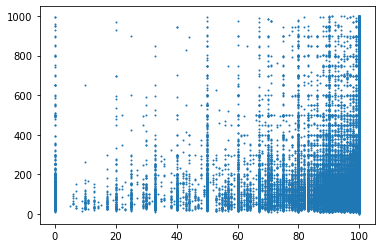

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

Y_array = np.array(Y)
X_array = np.array(Z["Host Response Rate"])

ax.scatter(X_array, Y_array, s = 1, )


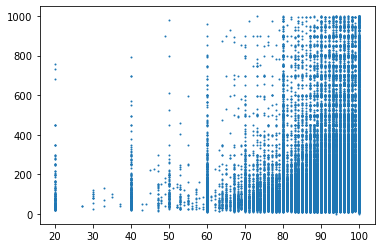

In [312]:
fig, ax = plt.subplots()

Y_array = np.array(Y)
X_array = np.array(Z["Review Scores Rating"])

ax.scatter(X_array, Y_array, s = 1, )

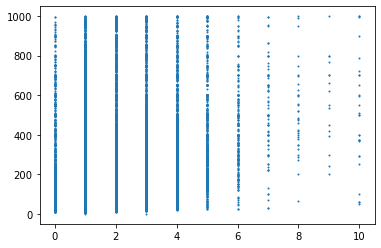

In [318]:
fig, ax = plt.subplots()

Y_array = np.array(Y)
X_array = np.array(Z["Bedrooms"])

ax.scatter(X_array, Y_array, s = 1, )

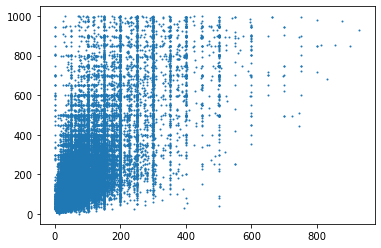

In [316]:
fig, ax = plt.subplots()

Y_array = np.array(Y)
X_array = np.array(airbnb5["Cleaning Fee"])

ax.scatter(X_array, Y_array, s = 1, )

In [311]:
fig, ax = plt.subplots()

Y_array = np.array(Y)
X_array = np.array(Z["Review Scores Location"])

ax.scatter(X_array, Y_array, s = 1, )

In [308]:
plt.hist(airbnb5["Country"])
plt.show()

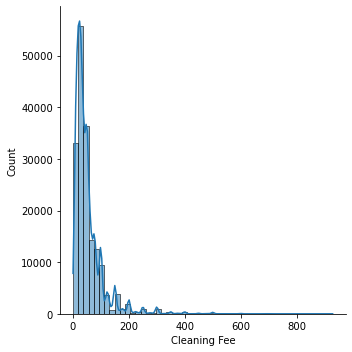

In [306]:
sns.displot(Z["Cleaning Fee"], kde=True, bins=50)

In [298]:

fig, ax = plt.subplots()

Y_array = np.array(Y)
X_array = np.array(Z["Accommodates"])
ax.scatter(X_array, Y_array, s = 1, )

Check first 5 Thumbnail Urls

In [47]:
airbnb5["Thumbnail Url"].iloc[0:5]

0    https://a0.muscache.com/im/pictures/eb9e20e1-9...
1    https://a0.muscache.com/im/pictures/4aad80ac-8...
2    https://a0.muscache.com/im/pictures/440cb88b-6...
3    https://a0.muscache.com/im/pictures/633ddf5e-a...
4    https://a0.muscache.com/im/pictures/3553991/bb...
Name: Thumbnail Url, dtype: object

Display a random image

In [48]:
url = airbnb5["Thumbnail Url"].iloc[137589]
response = requests.get(url)
if response.status_code == 200:    
    img = Image.open(BytesIO(response.content))
    img_array = np.array(img)
    print(img_array.shape)
    display(img)

(144, 216, 3)


Check shapes of the first one hundred images

In [49]:
img_shapes = []
for url in airbnb5.loc[:100,"Thumbnail Url"]:
    response = requests.get(url)
    if response.status_code == 200:    
        img = Image.open(BytesIO(response.content))
        img_array = np.array(img)
        img_shapes.append(img_array.shape)

img_shapes

[(144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 2

In [50]:
len(img_shapes)

68

Download images to folder in batches of 10000.
Some url links throw an error and images can't be downloaded, corresponding data rows in the data frame have to be filtered out.
Filenames contain the index of the images in order to select the corresponding row later.

In [96]:
import os
from urllib.parse import urlparse

output_folder = "images"
os.makedirs(output_folder, exist_ok=True)

urls = airbnb5.loc[:10000, "Thumbnail Url"]
for index, url in enumerate(urls):
    response = requests.get(url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        # If downloading in batches, adjust index to starting point in airbnb5 (e.g. if downloading [30000:40000, "Thumbnail Url"]
        # adjust index to index = index + 30000)
        index = index + 0
        filename = os.path.join(output_folder,f"image_{index}.jpg")
        try:
            if img.mode == "RGB":
                img.save(filename)
                print(f"saved image {index}")
            else:
                img.convert("RGB")
                img.save(filename)
                print(f"saved image {index}")
        except Exception as e:
            print(f"Error: {str(e)}")
            continue

saved image 0
saved image 1
saved image 5
saved image 6
saved image 7
saved image 8
saved image 9
saved image 10
saved image 14
saved image 18
saved image 19
saved image 20
saved image 21
saved image 22
saved image 23
saved image 26
saved image 28
saved image 29
saved image 31
saved image 32
saved image 33
saved image 34
saved image 36
saved image 37
saved image 40
saved image 41
saved image 42
saved image 45
saved image 46
saved image 48
saved image 49
saved image 50
saved image 53
saved image 54
saved image 55
saved image 57
saved image 58
saved image 59
saved image 60
saved image 61
saved image 62
saved image 64
saved image 67
saved image 69
saved image 70
saved image 71
saved image 72
saved image 73
saved image 76
saved image 77
saved image 79
saved image 80
saved image 81
saved image 82
saved image 84
saved image 85
saved image 86
saved image 87
saved image 89
saved image 90
saved image 92
saved image 93
saved image 94
saved image 95
saved image 97
saved image 98
saved image 99
sa

Check if indices match by comparing downloaded image with filename containing index i with image from url at index i in data frame airbnb5

In [610]:
airbnb5.loc[143239, "Thumbnail Url"]

'https://a0.muscache.com/im/pictures/3e2e18e0-6887-4d51-8bde-ff67d2d73b1e.jpg?aki_policy=small'

Load images into dictionary and extract index as key

In [611]:
index_image_map = {}

In [612]:

path = "images/"
all_files = os.listdir(path)

for f in all_files:
    try:
        index = int(f.split("_")[1].split(".")[0])
        image = Image.open(os.path.join(path,f))
        index_image_map[index] = np.array(image)
        image.close()
    except Exception as e:
        print(f"Error loading {f}: {str(e)}")


Error loading image_8932.jpg: cannot identify image file 'images/image_8932.jpg'
Error loading image_9059.jpg: cannot identify image file 'images/image_9059.jpg'
Error loading image_9332.jpg: cannot identify image file 'images/image_9332.jpg'
Error loading image_9678.jpg: cannot identify image file 'images/image_9678.jpg'
Error loading image_10262.jpg: cannot identify image file 'images/image_10262.jpg'
Error loading image_16583.jpg: cannot identify image file 'images/image_16583.jpg'
Error loading image_16607.jpg: cannot identify image file 'images/image_16607.jpg'
Error loading image_17085.jpg: cannot identify image file 'images/image_17085.jpg'
Error loading image_17170.jpg: cannot identify image file 'images/image_17170.jpg'
Error loading image_17962.jpg: cannot identify image file 'images/image_17962.jpg'
Error loading image_18472.jpg: cannot identify image file 'images/image_18472.jpg'
Error loading image_18474.jpg: cannot identify image file 'images/image_18474.jpg'
Error loadin

135175 of 135271 images could be loaded

In [613]:
len(index_image_map)

135175

Filter out images that are not of shape (144, 216, 3) (1.6%)

In [614]:
filtered = {}
target_shape = (144, 216, 3)
for index, image in list(index_image_map.items()):
    if image.shape == target_shape:
        filtered[index] = image
    else:
        print(f"image {index} removed with shape {image.shape}")

image 1695 removed with shape (800, 1200, 3)
image 1696 removed with shape (675, 1200, 3)
image 1697 removed with shape (800, 1200, 3)
image 1698 removed with shape (576, 1024, 3)
image 1699 removed with shape (800, 1200, 3)
image 1700 removed with shape (640, 480, 3)
image 1703 removed with shape (800, 1200, 3)
image 1704 removed with shape (798, 1200, 3)
image 1705 removed with shape (600, 800, 3)
image 1706 removed with shape (900, 1200, 3)
image 1708 removed with shape (800, 1200, 3)
image 1715 removed with shape (2122, 1200, 3)
image 1716 removed with shape (1600, 1200, 3)
image 1717 removed with shape (900, 1200, 3)
image 1718 removed with shape (800, 1200, 3)
image 1719 removed with shape (795, 1200, 3)
image 1720 removed with shape (798, 1200, 3)
image 1722 removed with shape (800, 1200, 3)
image 1724 removed with shape (805, 1200, 3)
image 1727 removed with shape (800, 1200, 3)
image 1728 removed with shape (800, 1200, 3)
image 1729 removed with shape (799, 1200, 3)
image 1734

In [615]:
len(filtered)

132992

Create list of images

In [616]:
images = list(filtered.values())
len(images)

132992

Check shapes

In [617]:
shapes = {}
for image in images:
    if image.shape in list(shapes.keys()):
        shapes[image.shape] += 1
    else:
        shapes[image.shape] = 1
shapes

{(144, 216, 3): 132992}

Load first 1000 images

In [348]:

path = "images/"
all_files = os.listdir(path)
images_test = []

for f in all_files:
    if len(images_test) == 1000:
        break
    try:
        image = Image.open(os.path.join(path,f))
        images_test.append(image)
    except Exception as e:
        print(f"Error loading {f}: {str(e)}")
images_test[0]

Use CLIP to calculate similarity between images and the words "room" and "apartment"

In [179]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [624]:
inputs = processor(text="room", images=images_test, return_tensors="pt")

In [625]:
with torch.no_grad():
    outputs = model(**inputs)

In [376]:
em = outputs.image_embeds.tolist()
len(em[0])

512

In [668]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

In [627]:
import numpy as np
logits_per_image = outputs.logits_per_image
logits_per_image_np = logits_per_image.detach().numpy()
logits_per_image_np = logits_per_image_np.reshape((logits_per_image_np.shape[0],))
logits_per_image_np.shape

(1000,)

Create boxplot of logits per image and calculate mean, median, standard deviation, lower whisker, fifth percentile, and tenth percentile

Mean: 24.528843
Median: 24.971561
Std: 2.4231596
Lower Whisker: 18.886534
Lower Percentile: 19.560523414611815


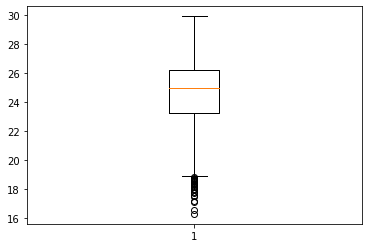

In [628]:
plt.boxplot(logits_per_image_np)
sim_mean = np.mean(logits_per_image_np)
print("Mean: " + str(sim_mean))
print("Median: " + str(np.median(logits_per_image_np)))
print("Std: " + str(np.std(logits_per_image_np)))
lower_quartile = np.percentile(logits_per_image_np, 25)
upper_quartile = np.percentile(logits_per_image_np, 75)
iqr = upper_quartile - lower_quartile
lower_whisker = logits_per_image_np[logits_per_image_np>lower_quartile-1.5*iqr].min()
print("Lower Whisker: " + str(lower_whisker))
fifth_percentile = np.percentile(logits_per_image_np, 5)
print("Lower Percentile: " + str(fifth_percentile))

Plot distribution of logits per image

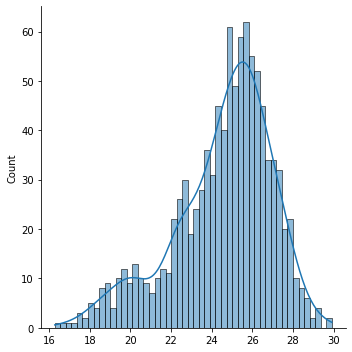

In [629]:
import seaborn as sns

sns.displot(logits_per_image_np, kde=True, bins=50)

Select images with similarity lower than the lower whisker to identify potentially irrelevant images

In [669]:
indices_outside_images = []
outliers = logits_per_image_np < lower_whisker
for i in range(len(outliers)):
    if outliers[i]:
        indices_outside_images.append(i)
logits_per_image_np[outliers]


array([18.986, 17.724, 19.724, 18.252, 19.689, 19.402, 18.589, 19.519,
       17.48 , 19.561, 19.567, 18.702, 18.52 , 18.029, 17.822, 19.179,
       19.772, 18.151, 18.74 , 19.376, 19.028, 19.554, 19.578, 18.936,
       18.989, 19.404, 16.276, 17.067, 18.373, 19.657, 16.56 , 19.453,
       19.753, 18.983, 18.887, 18.888, 17.495, 17.94 , 18.563, 18.357,
       19.117, 19.068, 17.143, 18.015, 18.66 , 19.495, 19.363, 19.756,
       18.109, 19.804, 18.481, 18.971, 19.336, 18.65 , 19.42 , 19.593,
       18.349, 17.519, 18.562, 19.491, 18.811], dtype=float32)

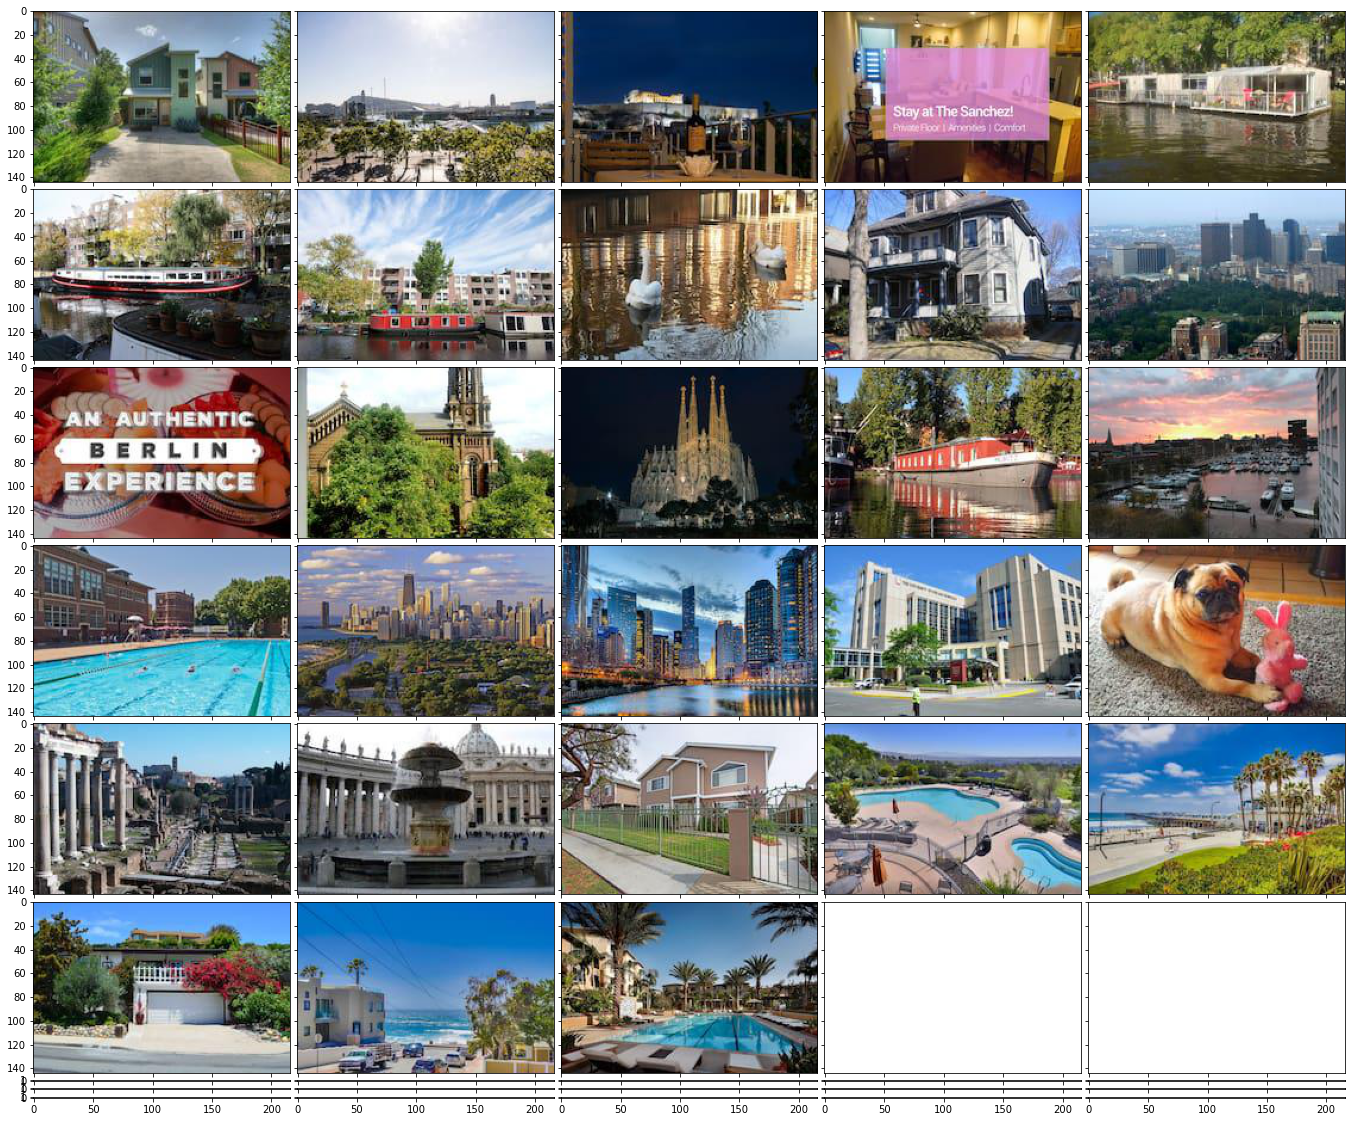

In [631]:
outside_images = []
for i in indices_outside_images:
    outside_images.append(images_test[i])

fig = plt.figure(1,(36.,20.))
grid = ImageGrid(fig, 111, nrows_ncols= (9,5), axes_pad=0.1,)

for i in range(len(indices_outside_images)):
    grid[i].imshow(outside_images[i])

Consider the fifth percentile as cutoff value

In [632]:
indices_outside_images2 = []
outliers2 = logits_per_image_np < fifth_percentile
for i in range(len(outliers2)):
    if outliers2[i]:
        indices_outside_images2.append(i)
logits_per_image_np[outliers2]

array([18.986, 17.724, 18.252, 19.402, 18.589, 19.519, 17.48 , 18.702,
       18.52 , 18.029, 17.822, 19.179, 18.151, 18.74 , 19.376, 19.028,
       19.554, 18.936, 18.989, 19.404, 16.276, 17.067, 18.373, 16.56 ,
       19.453, 18.983, 18.887, 18.888, 17.495, 17.94 , 18.563, 18.357,
       19.117, 19.068, 17.143, 18.015, 18.66 , 19.495, 19.363, 18.109,
       18.481, 18.971, 19.336, 18.65 , 19.42 , 18.349, 17.519, 18.562,
       19.491, 18.811], dtype=float32)

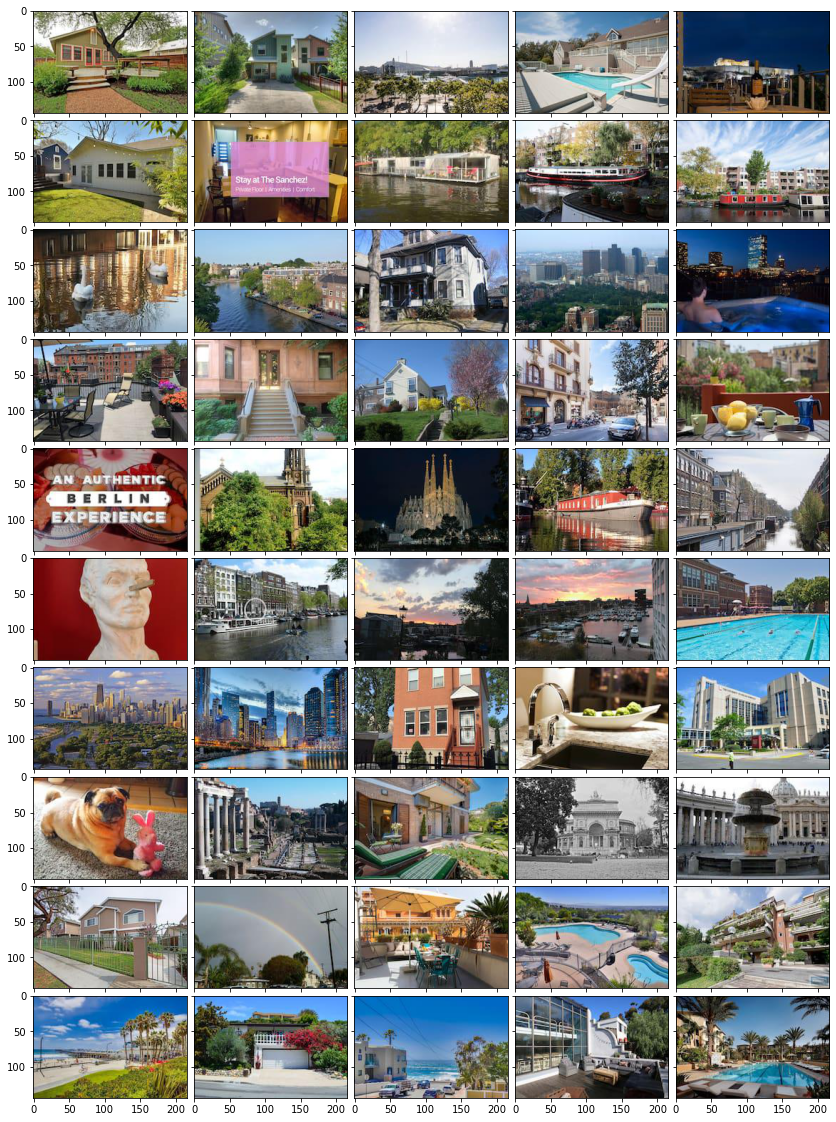

In [633]:
outside_images2 = []
for i in indices_outside_images2:
    outside_images2.append(images_test[i])

fig = plt.figure(1,(40.,20.))
grid = ImageGrid(fig, 111, nrows_ncols= (10,5), axes_pad=0.1,)

for i in range(len(indices_outside_images2)):
    grid[i].imshow(outside_images2[i])

Consider the tenth percentile as cutoff value

In [670]:
tenth_percentile = np.percentile(logits_per_image_np, 10)
tenth_percentile

20.871392440795898

In [671]:
indices_outside_images3 = []
outliers3 = logits_per_image_np < tenth_percentile
for i in range(len(outliers3)):
    if outliers3[i]:
        indices_outside_images3.append(i)
logits_per_image_np[outliers3]

array([19.894, 18.986, 17.724, 20.178, 19.724, 18.252, 19.689, 19.402,
       18.589, 19.519, 20.489, 17.48 , 19.843, 20.109, 20.436, 20.273,
       20.149, 20.422, 19.561, 20.393, 20.041, 19.567, 18.702, 18.52 ,
       18.029, 17.822, 19.179, 19.772, 18.151, 20.53 , 18.74 , 19.376,
       19.028, 19.554, 19.845, 20.232, 19.578, 20.865, 20.432, 20.673,
       20.719, 20.706, 18.936, 19.969, 18.989, 19.404, 20.156, 16.276,
       17.067, 18.373, 19.657, 20.71 , 20.044, 16.56 , 19.453, 19.753,
       18.983, 20.298, 20.275, 20.438, 18.887, 18.888, 17.495, 20.115,
       20.769, 20.512, 17.94 , 18.563, 18.357, 19.117, 19.068, 17.143,
       18.015, 20.451, 20.109, 18.66 , 19.915, 19.495, 19.363, 19.756,
       20.169, 20.507, 18.109, 19.889, 19.804, 18.481, 18.971, 20.669,
       19.336, 20.199, 18.65 , 19.42 , 19.593, 18.349, 20.163, 17.519,
       18.562, 19.491, 19.847, 18.811], dtype=float32)

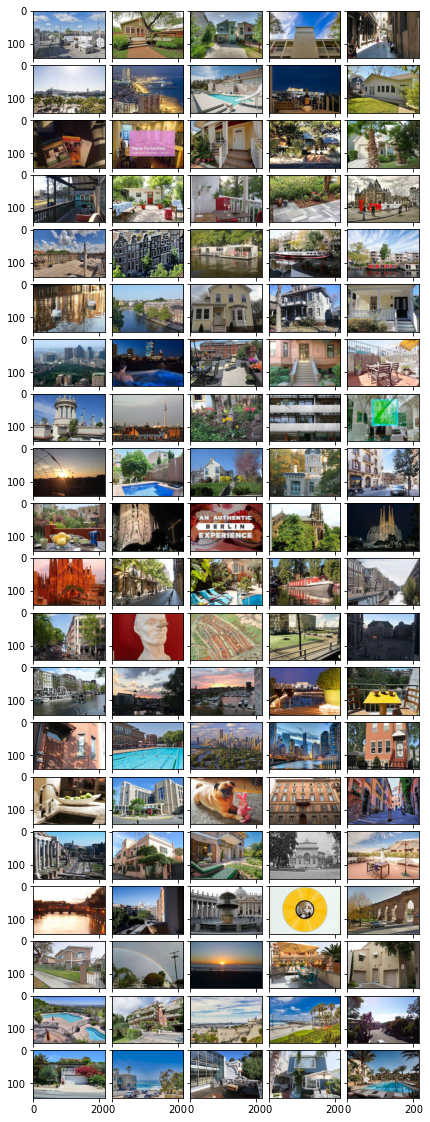

In [673]:
outside_images3 = []
for i in indices_outside_images3:
    outside_images3.append(images_test[i])

fig = plt.figure(1,(80.,20.))
grid = ImageGrid(fig, 111, nrows_ncols= (20,5), axes_pad=0.1,)

for i in range(len(indices_outside_images3)):
    grid[i].imshow(outside_images3[i])

Create filtered tabular data frames Z and Y corresponding to image indices

In [641]:
Z_filtered = Z.iloc[list(filtered.keys()),:]
Z_filtered = Z_filtered.reset_index(drop=True)
len(Z_filtered)

132992

In [642]:
Y_filtered = Y.iloc[list(filtered.keys())]
Y_filtered = Y_filtered.reset_index(drop=True)
len(Y_filtered)

132992

Pass images into CLIP and obtain similarity scores with "room", "apartment" as well as the image embeddings of size 512

In [643]:
batch_size = 128
num_batches = len(images) // batch_size + (len(images) % batch_size != 0)
X = []
similarity = []

for batchx in range(num_batches):
    startx = batchx * batch_size
    endx = min((batchx + 1) * batch_size, len(images))

    batch_images = images[startx:endx]
    print(f"processing images {startx} to {endx}")

    inputs = processor(text=["room", "apartment"], images=batch_images, return_tensors="pt")

    print("calculating similarity")

    with torch.no_grad():
        outputs = model(**inputs)
    
    X.extend(outputs.image_embeds)
    similarity.extend(outputs.logits_per_image)
    print(f"batch {batchx + 1} of {num_batches} processed")

processing images 0 to 128
calculating similarity
batch 1 of 1039 processed
processing images 128 to 256
calculating similarity
batch 2 of 1039 processed
processing images 256 to 384
calculating similarity
batch 3 of 1039 processed
processing images 384 to 512
calculating similarity
batch 4 of 1039 processed
processing images 512 to 640
calculating similarity
batch 5 of 1039 processed
processing images 640 to 768
calculating similarity
batch 6 of 1039 processed
processing images 768 to 896
calculating similarity
batch 7 of 1039 processed
processing images 896 to 1024
calculating similarity
batch 8 of 1039 processed
processing images 1024 to 1152
calculating similarity
batch 9 of 1039 processed
processing images 1152 to 1280
calculating similarity
batch 10 of 1039 processed
processing images 1280 to 1408
calculating similarity
batch 11 of 1039 processed
processing images 1408 to 1536
calculating similarity
batch 12 of 1039 processed
processing images 1536 to 1664
calculating similarity


Create numpy arrays for similarity scores

In [657]:
similarity_room = [pair[0] for pair in similarity]
similarity_room = np.array(similarity_room)
similarity_room.shape

24.884232

In [661]:
similarity_ap = [pair[1] for pair in similarity]
similarity_ap = np.array(similarity_ap)
similarity_ap.shape

(132992,)

In [645]:
len(X)

132992

Plot distribution of similarity scores

In [664]:
sns.displot(similarity_room, kde=True, bins=50)

In [665]:
sns.displot(similarity_ap, kde=True, bins=50)

Repeat process from first 1000 images, creating box plots for similarity scores and calculate statistics

Mean: 24.042707
Median: 24.502666
Std: 2.5299182
Fifth Percentile: 19.006230163574216
Tenth Percentile: 20.08373889923096


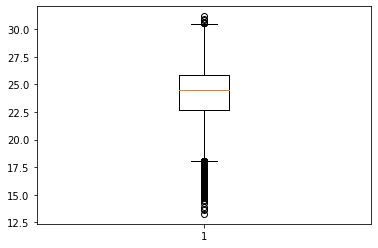

In [674]:
plt.boxplot(similarity_room)
sim_mean_room = np.mean(similarity_room)
print("Mean: " + str(sim_mean_room))
print("Median: " + str(np.median(similarity_room)))
print("Std: " + str(np.std(similarity_room)))
fifth_percentile_room = np.percentile(similarity_room, 5)
print("Fifth Percentile: " + str(fifth_percentile_room))
tenth_percentile_room = np.percentile(similarity_room, 10)
print("Tenth Percentile: " + str(tenth_percentile_room))

Mean: 24.662054
Median: 25.14646
Std: 2.2591455
Fifth Percentile: 20.066510105133055
Tenth Percentile: 21.494503021240234


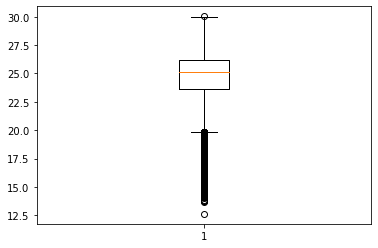

In [675]:
plt.boxplot(similarity_ap)
sim_mean_ap = np.mean(similarity_ap)
print("Mean: " + str(sim_mean_ap))
print("Median: " + str(np.median(similarity_ap)))
print("Std: " + str(np.std(similarity_ap)))
fifth_percentile_ap = np.percentile(similarity_ap, 5)
print("Fifth Percentile: " + str(fifth_percentile_ap))
tenth_percentile_ap = np.percentile(similarity_ap, 10)
print("Tenth Percentile: " + str(tenth_percentile_ap))

Filter out potentially irrelevant images based on observations from looking at first 1000 images

In [677]:
indices_irrelevant = []
outliers_ap = similarity_ap < tenth_percentile_ap
for i in range(len(outliers_ap)):
    if outliers_ap[i]:
        indices_irrelevant.append(i)
len(similarity_ap[indices_irrelevant])

13300

In [679]:
outliers_room = similarity_room < tenth_percentile_room
for i in range(len(outliers_room)):
    if outliers_room[i]:
        if not i in indices_irrelevant:
            indices_irrelevant.append(i)
len(similarity_ap[indices_irrelevant])

17335

In [682]:
print(similarity_ap[outliers_ap].max())
print(similarity_room[outliers_room].max())

21.494497
20.08373


Convert embeddings into Data Frame

In [686]:
X_np = [embedding.numpy() for embedding in X]
X_df = pd.DataFrame(X_np)
X_df.shape

(132992, 512)

In [722]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

X_train, X_test, Z_train, Z_test, Y_train, Y_test = train_test_split(X_df, Z_filtered, Y_filtered, test_size=1/3, random_state=1)
print(X_train.shape, X_test.shape, Z_train.shape, Z_test.shape, Y_train.shape, Y_test.shape)

(88661, 512) (44331, 512) (88661, 360) (44331, 360) (88661,) (44331,)


Normalize continuous variables in Z and X 

In [723]:
def normalize_Z(Z_train, Z_test):
    scaler = StandardScaler().fit(Z_train.iloc[:,:24])
    Z_train_normal = scaler.transform(Z_train.iloc[:,:24])
    Z_test_normal = scaler.transform(Z_test.iloc[:,:24])
    Z_train_normal = pd.DataFrame(Z_train_normal, columns = Z_train.iloc[:,:24].columns)
    Z_test_normal = pd.DataFrame(Z_test_normal, columns = Z_test.iloc[:,:24].columns)
    Z_train_normal = pd.concat([Z_train_normal, Z_train.iloc[:,24:].reset_index(drop=True)], axis=1)
    Z_test_normal = pd.concat([Z_test_normal, Z_test.iloc[:,24:].reset_index(drop=True)], axis=1)
    return Z_train_normal, Z_test_normal

In [724]:
Z_test_train_normal, Z_test_normal = normalize_Z(Z_train, Z_test)

In [725]:
def normalize_X(X_train, X_test):
    scalerX = StandardScaler().fit(X_train)
    X_train_normal = scalerX.transform(X_train)
    X_test_normal = scalerX.transform(X_test)
    X_train_normal = pd.DataFrame(X_train_normal, columns = X_train.columns)
    X_test_normal = pd.DataFrame(X_test_normal, columns = X_test.columns)
    return X_train_normal, X_test_normal

In [726]:
X_train_normal, X_test_normal = normalize_X(X_train, X_test)
X_train_normal.shape

(88661, 512)

Create combined Data Frames ZX_train and ZX_test

In [727]:
def create_ZX(Z_train, Z_test, X_train, X_test):
    ZX_train = pd.concat([Z_train, X_train], axis=1)
    ZX_test = pd.concat([Z_test, X_test], axis=1)
    return ZX_train, ZX_test

In [728]:
ZX_train, ZX_test = create_ZX(Z_train_normal, Z_test_normal, X_train_normal, X_test_normal)
ZX_train.shape

(88661, 872)

In [729]:
Y_train = Y_train.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)
Y_train.head()

0    185.0
1     25.0
2     85.0
3     35.0
4    249.0
Name: Price, dtype: float64

Predict Y from Z using Linear Regression as benchmark

In [730]:
import statsmodels.api as sm

Z_train_sm = sm.add_constant(Z_train_normal)
Z_test_sm = sm.add_constant(Z_test_normal)
reg1 = sm.OLS(Y_train, Z_train_sm).fit()

print(reg1.summary())
Y_hat_train = reg1.predict(Z_train_sm)
train_error_reg1 = np.sqrt(mean_squared_error(Y_train, Y_hat_train))
print("Train error: " + str(train_error_reg1))

Y_hat = reg1.predict(Z_test_sm)
test_error_reg1 = np.sqrt(mean_squared_error(Y_test, Y_hat))
print("Test error: " + str(test_error_reg1))

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     881.8
Date:                Mon, 25 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:33:54   Log-Likelihood:            -4.9389e+05
No. Observations:               88661   AIC:                         9.884e+05
Df Residuals:                   88336   BIC:                         9.915e+05
Df Model:                         324                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

Predict Y from Z and X using linear regression

In [731]:
ZX_train_sm = sm.add_constant(ZX_train)
ZX_test_sm = sm.add_constant(ZX_test)
regZX = sm.OLS(Y_train, ZX_train_sm).fit()

print(regZX.summary())
pred_train_ZX = regZX.predict(ZX_train_sm)
train_error_regZX = np.sqrt(mean_squared_error(Y_train, pred_train_ZX))
print("Train error: " + str(train_error_regZX))

pred_ZX = regZX.predict(ZX_test_sm)
test_error_regZX = np.sqrt(mean_squared_error(Y_test, pred_ZX))
print("Test error: " + str(test_error_regZX))

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     358.8
Date:                Mon, 25 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:34:09   Log-Likelihood:            -4.9204e+05
No. Observations:               88661   AIC:                         9.858e+05
Df Residuals:                   87824   BIC:                         9.936e+05
Df Model:                         836                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

Create Data Frames containing rows corresponding to relevant images

In [732]:
X_relevant = X_df.drop(labels=indices_irrelevant, axis=0)
len(X_relevant)

115657

In [717]:
Z_relevant = Z_filtered.drop(labels=indices_irrelevant, axis=0)
len(Z_relevant)

115657

In [718]:
Y_relevant = Y_filtered.drop(labels=indices_irrelevant, axis=0)
len(Y_relevant)

115657

Create train and test sets

In [760]:
X_train_r, X_test_r, Z_train_r, Z_test_r, Y_train_r, Y_test_r = train_test_split(X_relevant, Z_relevant, Y_relevant, test_size=1/3, random_state=111)
print(X_train_r.shape, X_test_r.shape, Z_train_r.shape, Z_test_r.shape, Y_train_r.shape, Y_test_r.shape)

(77104, 512) (38553, 512) (77104, 360) (38553, 360) (77104,) (38553,)


In [761]:
Z_train_r, Z_test_r = normalize_Z(Z_train_r, Z_test_r)
X_train_r, X_test_r = normalize_X(X_train_r, X_test_r)

In [763]:
Y_train_r = Y_train_r.reset_index(drop=True)
Y_test_r = Y_test_r.reset_index(drop=True)
Y_train_r.shape

(77104,)

In [764]:
ZX_train_r, ZX_test_r = create_ZX(Z_train_r, Z_test_r, X_train_r, X_test_r)
ZX_test_r.shape

(38553, 872)

In [765]:
Z_train_sm = sm.add_constant(Z_train_r)
Z_test_sm = sm.add_constant(Z_test_r)
reg1 = sm.OLS(Y_train_r, Z_train_sm).fit()

print(reg1.summary())
Y_hat_train = reg1.predict(Z_train_sm)
train_error_reg1 = np.sqrt(mean_squared_error(Y_train_r, Y_hat_train))
print("Train error: " + str(train_error_reg1))

Y_hat = reg1.predict(Z_test_sm)
test_error_reg1 = np.sqrt(mean_squared_error(Y_test_r, Y_hat))
print("Test error: " + str(test_error_reg1))

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     877.3
Date:                Mon, 25 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:08:06   Log-Likelihood:            -4.2587e+05
No. Observations:               77104   AIC:                         8.524e+05
Df Residuals:                   76794   BIC:                         8.552e+05
Df Model:                         309                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [766]:
ZX_train_sm = sm.add_constant(ZX_train_r)
ZX_test_sm = sm.add_constant(ZX_test_r)
reg1 = sm.OLS(Y_train_r, ZX_train_sm).fit()

print(reg1.summary())
Y_hat_train = reg1.predict(ZX_train_sm)
train_error_reg1 = np.sqrt(mean_squared_error(Y_train_r, Y_hat_train))
print("Train error: " + str(train_error_reg1))

Y_hat = reg1.predict(ZX_test_sm)
test_error_reg1 = np.sqrt(mean_squared_error(Y_test_r, Y_hat))
print("Test error: " + str(test_error_reg1))

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     347.1
Date:                Mon, 25 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:08:23   Log-Likelihood:            -4.2417e+05
No. Observations:               77104   AIC:                         8.500e+05
Df Residuals:                   76282   BIC:                         8.576e+05
Df Model:                         821                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

Fast Conditional Independence Test using fcit package

In [386]:
from fcit import fcit

In [755]:
ZX = pd.concat([ZX_train_r, ZX_test_r], axis=0)
Z_new = np.array(ZX.iloc[:,:360])
X_new = np.array(ZX.iloc[:,360:])
X_new.shape

(115657, 512)

In [757]:
Y_new = pd.concat([Y_train_r, Y_test_r], axis=0)
Y_new = np.array(Y_new).reshape(115657,1)
Y_new.shape

(115657, 1)

In [768]:
p_value = fcit.test(X_new, Y_new, verbose = True)
p_value

min_samples_split: 0.2.
min_samples_split: 0.4.
D0 statistics: [0.952 1.078 1.109 1.089 0.975 1.013 1.001 1.067]
D1 statistics: [0.886 0.999 1.037 1.017 0.917 0.952 0.942 0.994]



3.646377153288291e-09

Manually download package mlxtend, as installation resulted in an error

In [461]:
import sys

path_mlxtend = "/home/RDC/karpfvin/Schreibtisch/Object_importance/rasbt-mlxtend-6585e23/"
sys.path.append(path_mlxtend)

import mlxtend

In [462]:
from pcit import IndependenceTest, MetaEstimator, StructureEstimation

In [767]:
IndependenceTest.PCIT(Y_new, X_new, z = Z_new)

KeyboardInterrupt: 